In [13]:
import clip 
import torch 
import pickle
import argparse
import numpy as np
import os
os.sys.path.append('/home/mandi/ARM')
os.sys.path.append('/home/mandi/ARM/irl')
from models import RewardMLP
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from PIL import Image
from os.path import join
from omegaconf import DictConfig, OmegaConf
DATA_PATH='/home/mandi/ARM/irl/CLIP_ARM'
from r3m import load_r3m
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomResizedCrop
try:
    from torchvision.transforms import InterpolationMode 
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
%matplotlib inline
DATA_PATH='/home/mandi/ARM/irl/CLIP_ARM'

## Prepare CLIP

In [10]:
device = 'cuda:0'
model_name = "ViT-L/14" 
clip_model, preprocess = clip.load(model_name, device=device)
print('loaded CLIP model')
prompts = ["robot gripper tip touch square button"]
text = clip.tokenize(prompts).to(device)
print('Using prompt', prompts)

In [6]:
model_path = '/home/mandi/ARM/irl/clip-tuned/'
model_name = 'Button-Latest-ConcatBatch-2x100Batch-256x512MLP'
step = 100 
cfg = OmegaConf.load(join(model_path, model_name, 'config.yaml'))
mlp = RewardMLP(clip_model, **cfg.model)
mlp.load_state_dict(torch.load(f'{model_path}/{model_name}/{step}.pt'))
print('Loaded model from {}, step {}'.format(model_name, step))

Loaded model from Button-Latest-ConcatBatch-2x100Batch-256x512MLP, step 100


In [152]:
# new_clip, new_preprocess = clip.load('ViT-L/14@336px', device=device)
import pandas as pd
pd.read_csv('/shared/ademi_adeniji/r3m/rlbenchmanifest.csv')

Unnamed: 0                   txt  len  \
0                0  put_bottle_in_fridge  524   
1                1  put_bottle_in_fridge  524   
2                2  put_bottle_in_fridge  524   
3                3  put_bottle_in_fridge  524   
4                4  put_bottle_in_fridge  524   
...            ...                   ...  ...   
157495      157495        open_microwave  221   
157496      157496        open_microwave  221   
157497      157497        open_microwave  221   
157498      157498        open_microwave  221   
157499      157499        open_microwave  221   

                                                     path  
0       /shared/mandi/all_rlbench_data/put_bottle_in_f...  
1       /shared/mandi/all_rlbench_data/put_bottle_in_f...  
2       /shared/mandi/all_rlbench_data/put_bottle_in_f...  
3       /shared/mandi/all_rlbench_data/put_bottle_in_f...  
4       /shared/mandi/all_rlbench_data/put_bottle_in_f...  
...                                                   ...  
157495  /shared/mandi/all_rlbench_data/open_microwave/...  
157496  /shared/mandi/all_rlbench_data/open_microwave/...  
157497  /shared/mandi/all_rlbench_data/open_microwave/...  
157498  /shared/mandi/all_rlbench_data/open_microwave/...  
157499  /shared/mandi/all_rlbench_data/open_microwave/...  

[157500 rows x 4 columns]

In [19]:
def compute_logits(all_imgs, mlp, device, aug_avg=False, aug_num=3):
    all_logits = []
    mlp = mlp.to(device)
    for imgs in all_imgs:
        if aug_avg:
            logits = 0
            for _ in range(aug_num):
                img_batch = torch.stack([aug_process(img) for img in imgs]).to(device)
                logits += mlp(img_batch, text).detach().cpu().numpy()
            logits /= aug_num
        else:
            img_batch = torch.stack([preprocess(img) for img in imgs]).to(device)
            logits = mlp(img_batch, text).detach().cpu().numpy()
        all_logits.append(logits)
    return all_logits

## Prepare R3M 

In [3]:
import r3m as r3m
#r3m = load_r3m('resnet50').to('cuda:0')
mod_path = "/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-04-24_22-09-30/snapshot_240000.pt"
r3m = r3m.load_r3m("resnet50", model_path=mod_path).to('cuda:0')
r3m.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

## Load either demos or agent fail/success episodes

In [8]:
all_task_imgs=dict()
all_task_rewards = dict()

In [4]:
def load_demos(task='push_button', var=0, num_eps=5,camera='right_shoulder',interval=10):
    print('Getting demos for task', task)
    paths = [ f'/home/mandi/all_rlbench_data/{task}/variation{var}/episodes/episode{eps}/{camera}_rgb/*' \
            for eps in range(num_eps)]
    assert len(paths) > 0, 'file not found!'
    all_imgs = []
    for path in paths:
        frames = natsorted(glob(path)) 
        frames = [frames[i] for i in range(0, len(frames), interval)]
        imgs = [Image.open(p) for p in frames]
        all_imgs.append(imgs)
        print(len(imgs))
    return all_imgs

def get_imgs(task='push_button',traj_path='iteration0/fail', n_paths=10):
    paths = glob(join(DATA_PATH, task, traj_path, f'episode*'))
    long_paths = natsorted([p for p in paths if len(glob(join(p, '*'))) >= 3 ])
    vis_paths = long_paths[:n_paths]
    all_imgs = []
    for path in vis_paths:
        steps = natsorted(glob(f'{path}/*.pkl'))
        imgs = []
        for i, step in enumerate(steps):
            with open(step, 'rb') as f:
                transition = pickle.load(f)
            obs = transition.observation['front_rgb']
            if obs.shape[-1] != 3 and obs.shape[0] == 3:
                obs = obs.transpose(1,2,0)
            obs = Image.fromarray(np.uint8(obs))
            imgs.append(obs)

            if i == len(steps) - 1:
                final_obs = transition.final_observation['front_rgb']
                if final_obs.shape[-1] != 3 and final_obs.shape[0] == 3:
                    final_obs = final_obs.transpose(1,2,0)
                    obs = Image.fromarray(np.uint8(final_obs))
                    imgs.append(obs)
        all_imgs.append(imgs)
        print(f'Loaded {len(imgs)} imgs from path {path}')
    return all_imgs

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomResizedCrop
try:
    from torchvision.transforms import InterpolationMode 
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip

def _convert_image_to_rgb(image):
    return image.convert("RGB")

aug_process = Compose([
            Resize(240, interpolation=BICUBIC),
            RandomResizedCrop(224, scale=(0.7, 1.0)),
            RandomHorizontalFlip(0.5),
            _convert_image_to_rgb,
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

In [66]:
fail_imgs = get_imgs()

Loaded 5 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode14
Loaded 4 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode89
Loaded 4 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode106
Loaded 6 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode193
Loaded 5 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode198
Loaded 4 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode203
Loaded 6 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode217
Loaded 4 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode223
Loaded 11 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode242
Loaded 4 imgs from path /home/mandi/ARM/irl/CLIP_ARM/push_button/iteration0/fail/episode311


In [111]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fb6934839e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [20]:
fail_clip_logits = compute_logits(fail_imgs, mlp, device)

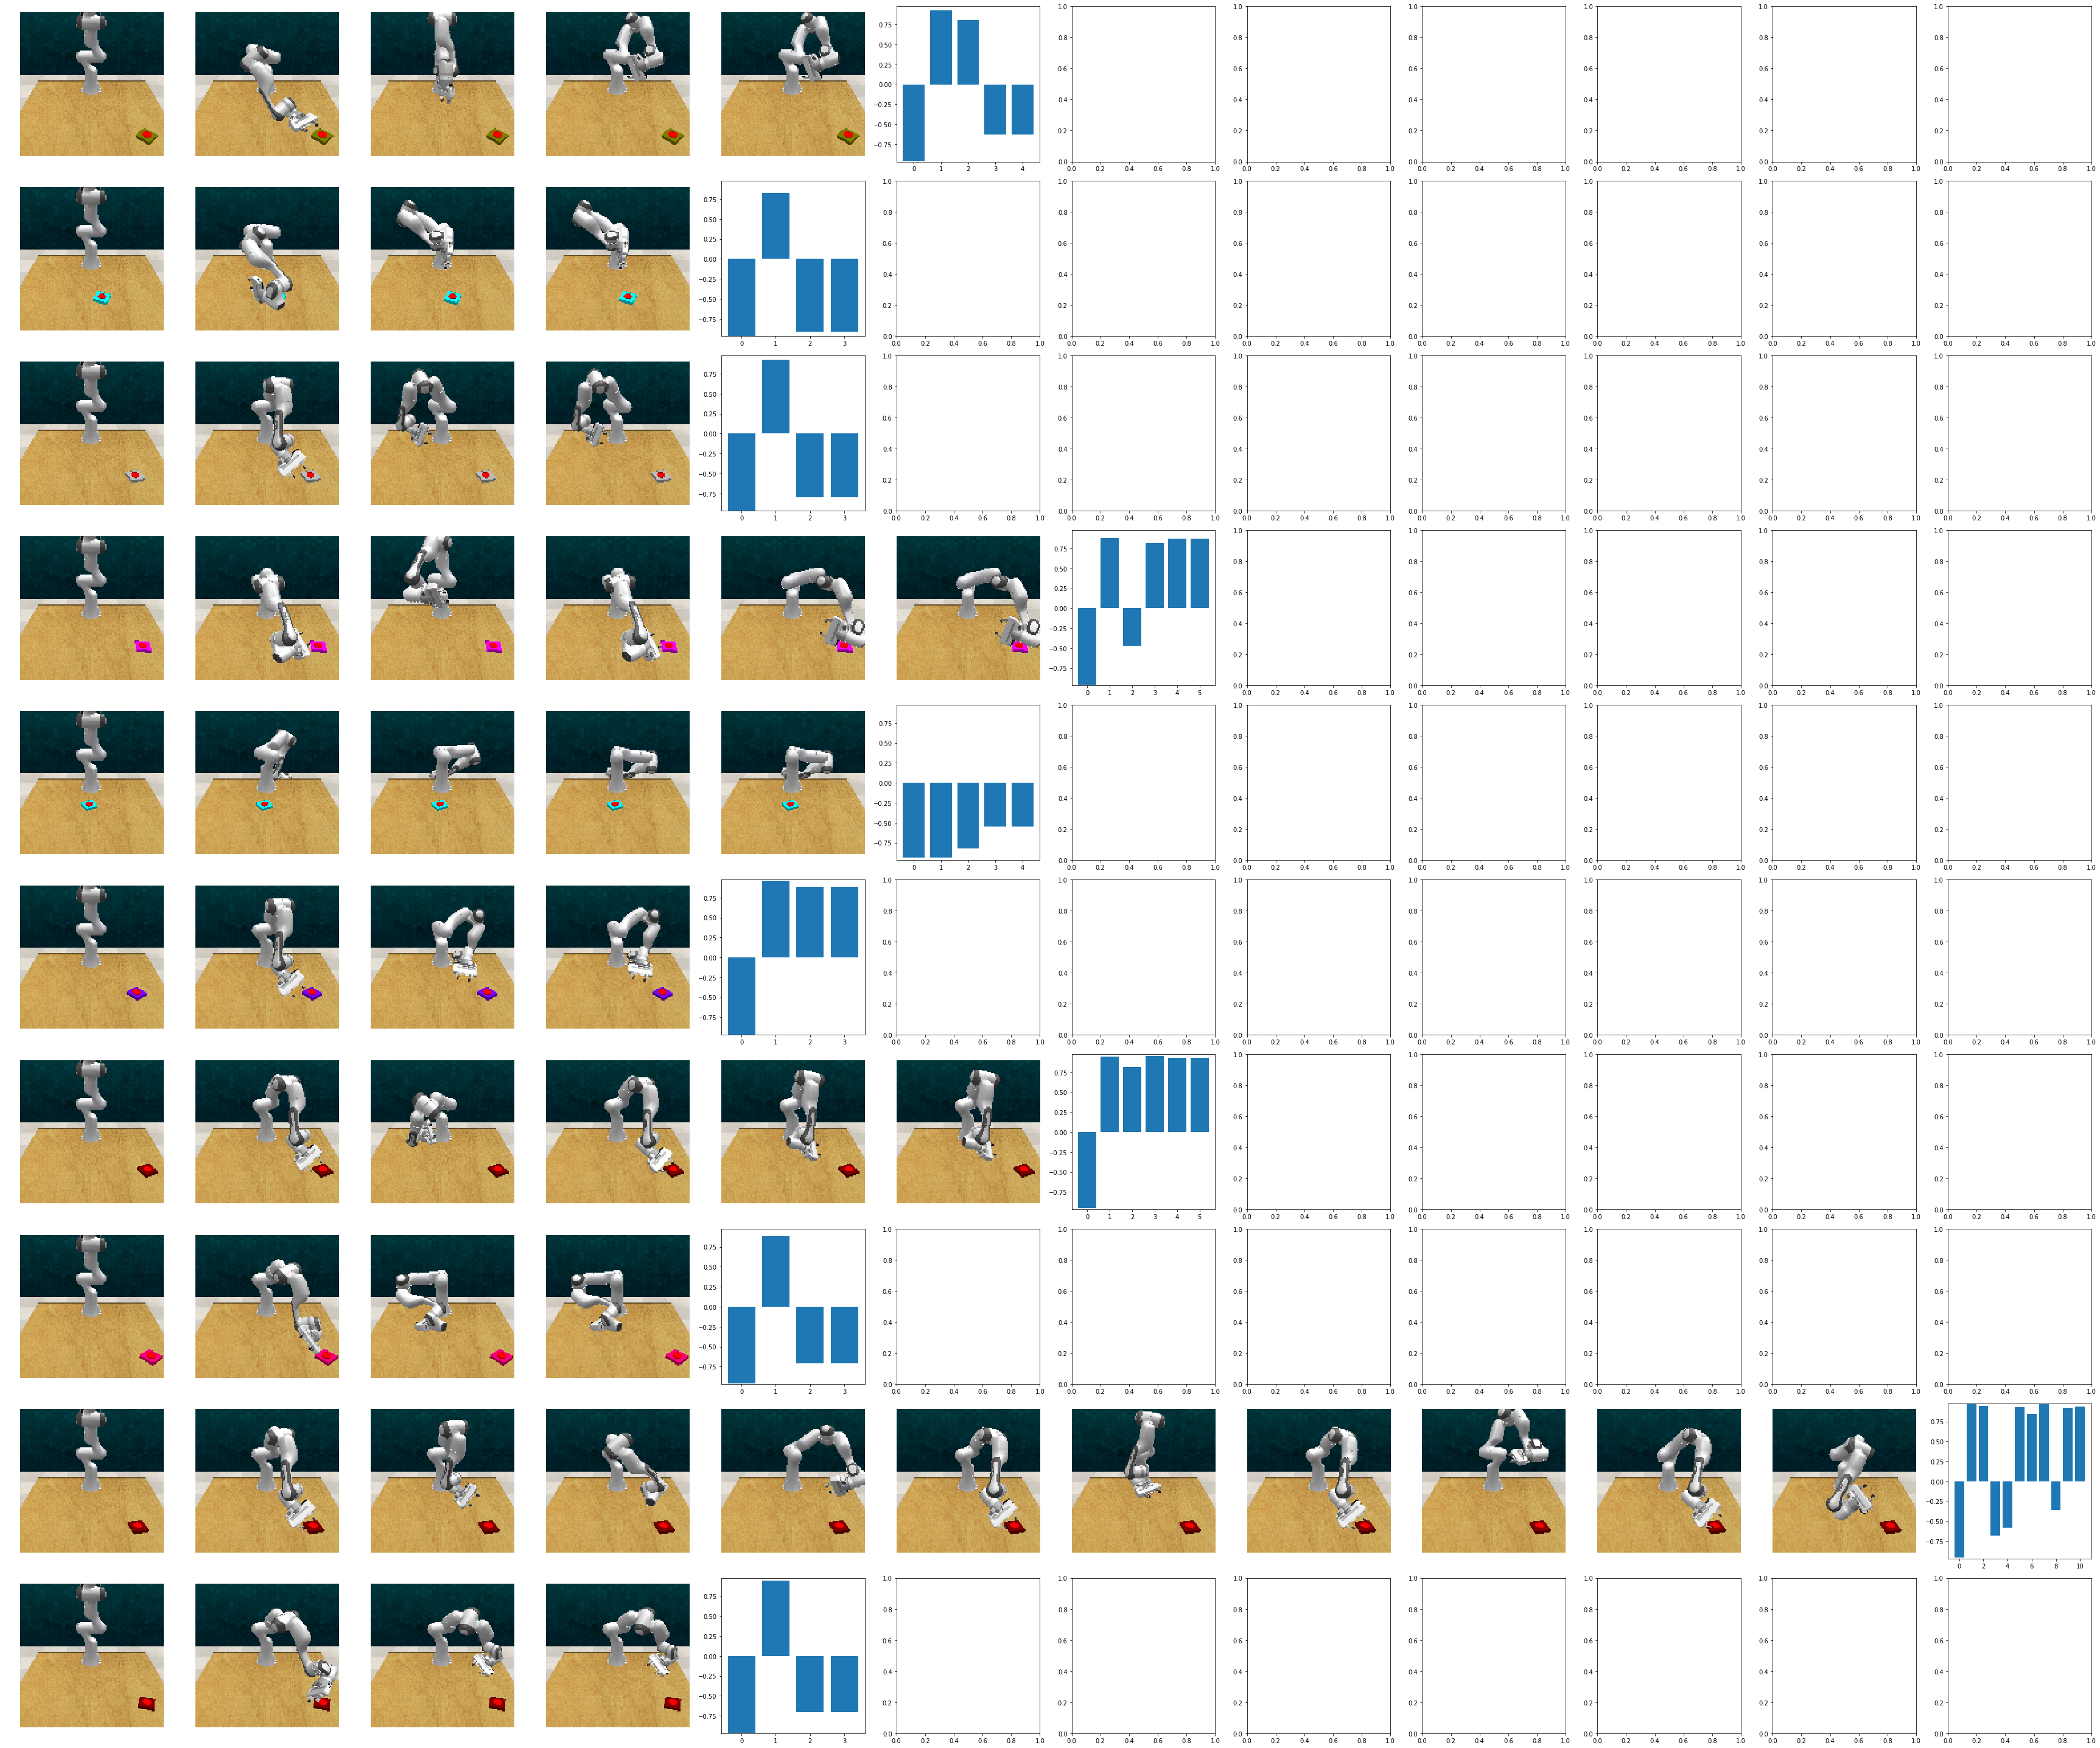

In [21]:
def show_logits(all_logits, all_imgs):
    ymax = max([max(logits) for logits in all_logits])
    ymin = min([min(logits) for logits in all_logits])
    
    max_traj_len = max([len(imgs) for imgs in all_imgs])
    fig, axs = plt.subplots(len(all_imgs), max_traj_len + 1, squeeze=False, figsize=(max_traj_len*4+4, 4*len(all_imgs)))
    for i, imgs in enumerate(all_imgs):
        for j, img in enumerate(imgs):
            r = i
            axs[r,j].imshow(imgs[j])
            axs[r,j].axis('off')
        #print(list(range(j)), all_logits[i].flatten().shape)
        axs[r,j+1].bar(x=list(range(j+1)), height=all_logits[i].flatten())
        axs[r,j+1].set_ylim(ymin, ymax) 
    plt.tight_layout()
show_logits(fail_clip_logits, fail_imgs)

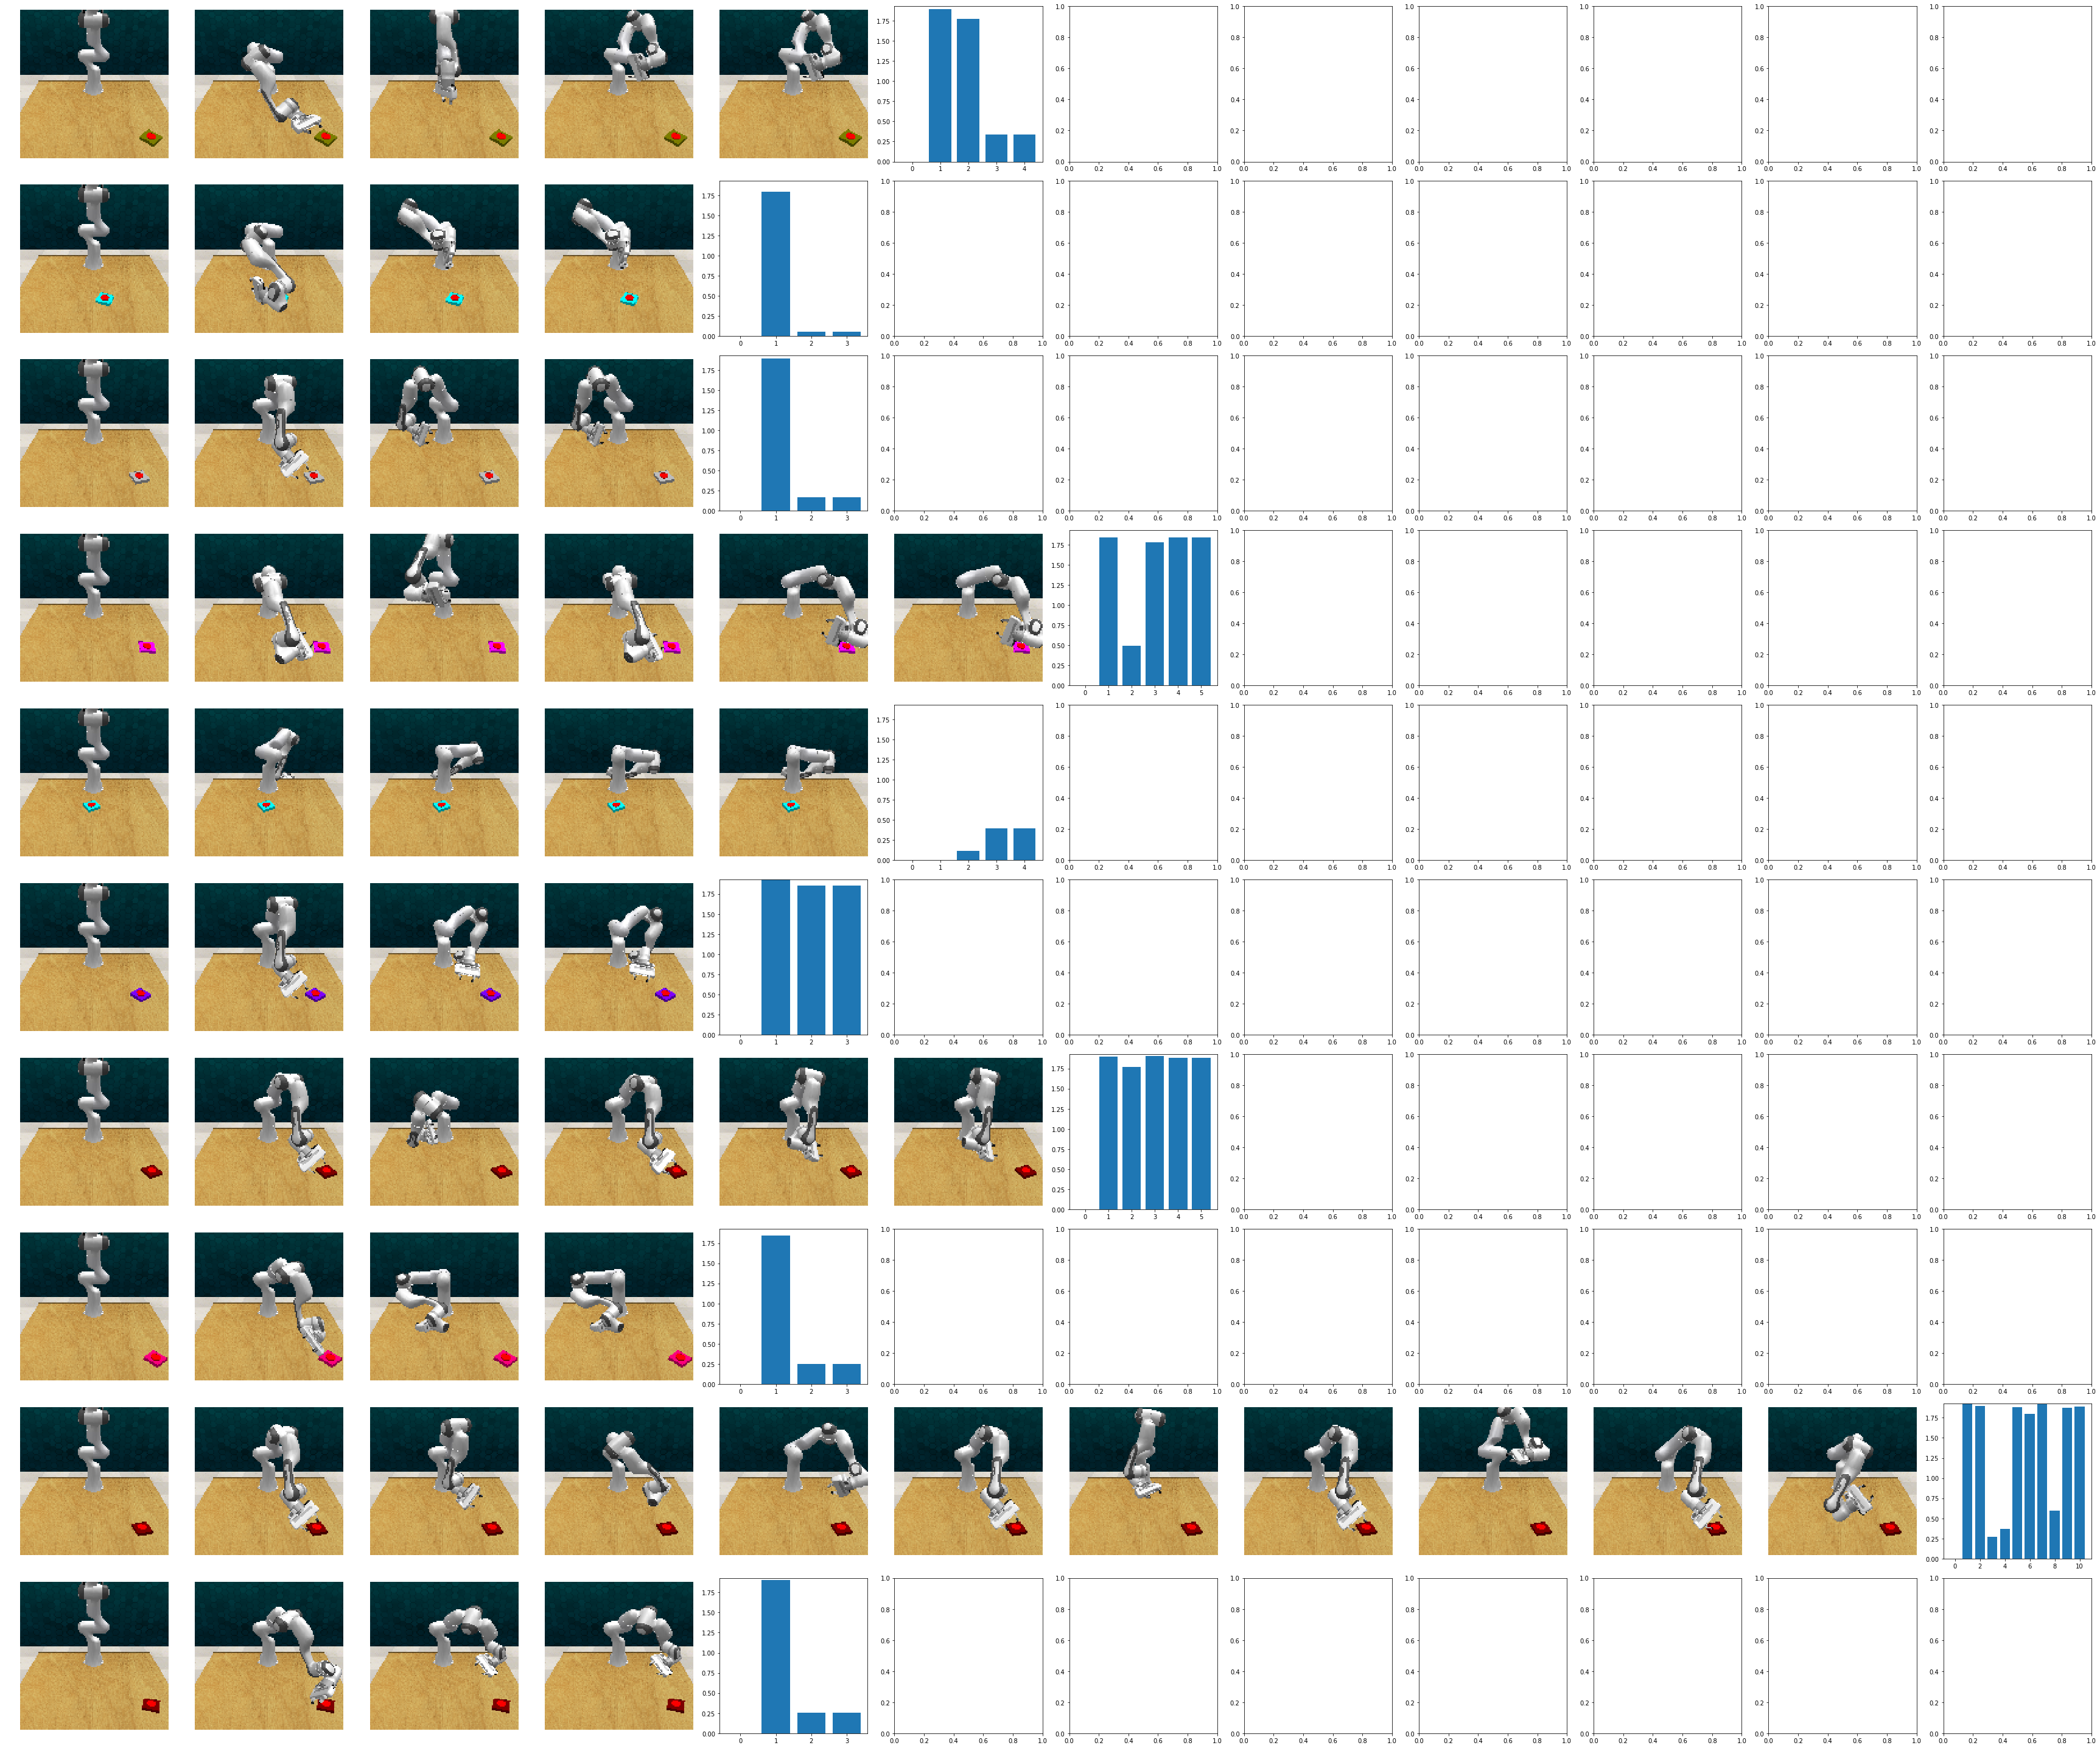

In [25]:
# Not a good idea to subtract first frame 
subtracted_clip_logits = [logits - logits[0] for logits in fail_clip_logits]
show_logits(subtracted_clip_logits, fail_imgs)

In [63]:
# r3m_process = Compose([
#         _convert_image_to_rgb,
#         RandomResizedCrop(128, scale=(0.7, 1)), 
#         ToTensor()
#     ])
r3m_process = Compose([
#         _convert_image_to_rgb,
        ToTensor(),
        torch.nn.Upsample(224, mode='linear', align_corners=False),
        
    ])
def get_r3m_rewards(all_imgs, text="robot gripper push button"):
    print("Using caption", text)
    lang = np.array([text])
    all_rewards = []

    for imgs in all_imgs:
        rewards = []
        #print(r3m_process(imgs[0]))
        img_batch = torch.stack([r3m_process(img) for img in imgs]).to(device)
        #frames = (img_batch) * 2 - 1
        frames = img_batch * 255.0
        #print(img_batch.max(), img_batch.min(), frames.max(), frames.min(), frames.shape)
        #start = r3m(frames[0][None])
        ends = r3m(frames)
        start = ends[0][None]
        for i in range(len(imgs)):
            rewards.append(r3m.module.get_reward(start, ends[i][None], lang)[0].cpu().detach())
        all_rewards.append([r-rewards[0] for r in rewards])
        print('One traj done')
    return all_rewards

# plt.xlabel("num frames from start frame")
# plt.ylabel("reward")
# plt.title("r3m vid-lang alignment scores for " + lang[0])
def show_r3m_rewards(all_imgs, all_rewards):
    max_traj_len = max([len(imgs) for imgs in all_imgs])
    
    ymax = max([max(logits) for logits in all_rewards])
    ymin = min([min(logits) for logits in all_rewards])
    fig, axs = plt.subplots(len(all_imgs), max_traj_len+1, squeeze=True, figsize=(max_traj_len*4+5, 4*len(all_imgs)))
    for i, imgs in enumerate(all_imgs):
        for j, img in enumerate(imgs):
            r = i
            axs[r,j].imshow(imgs[j])
            axs[r,j].axis('off') 

        axs[r,j+1].bar(x=list(range(j+1)), height=all_rewards[i]) #bar(x=list(range(j+1)), height=all_logits[i].flatten())
    axs[-1,0].set_ylim(ymin, ymax) 
    plt.tight_layout()

Getting demos for task put_umbrella_in_umbrella_stand
17
11
13
9
13
Using caption put umbrella in umbrella stand
One traj done
One traj done
One traj done
One traj done
One traj done


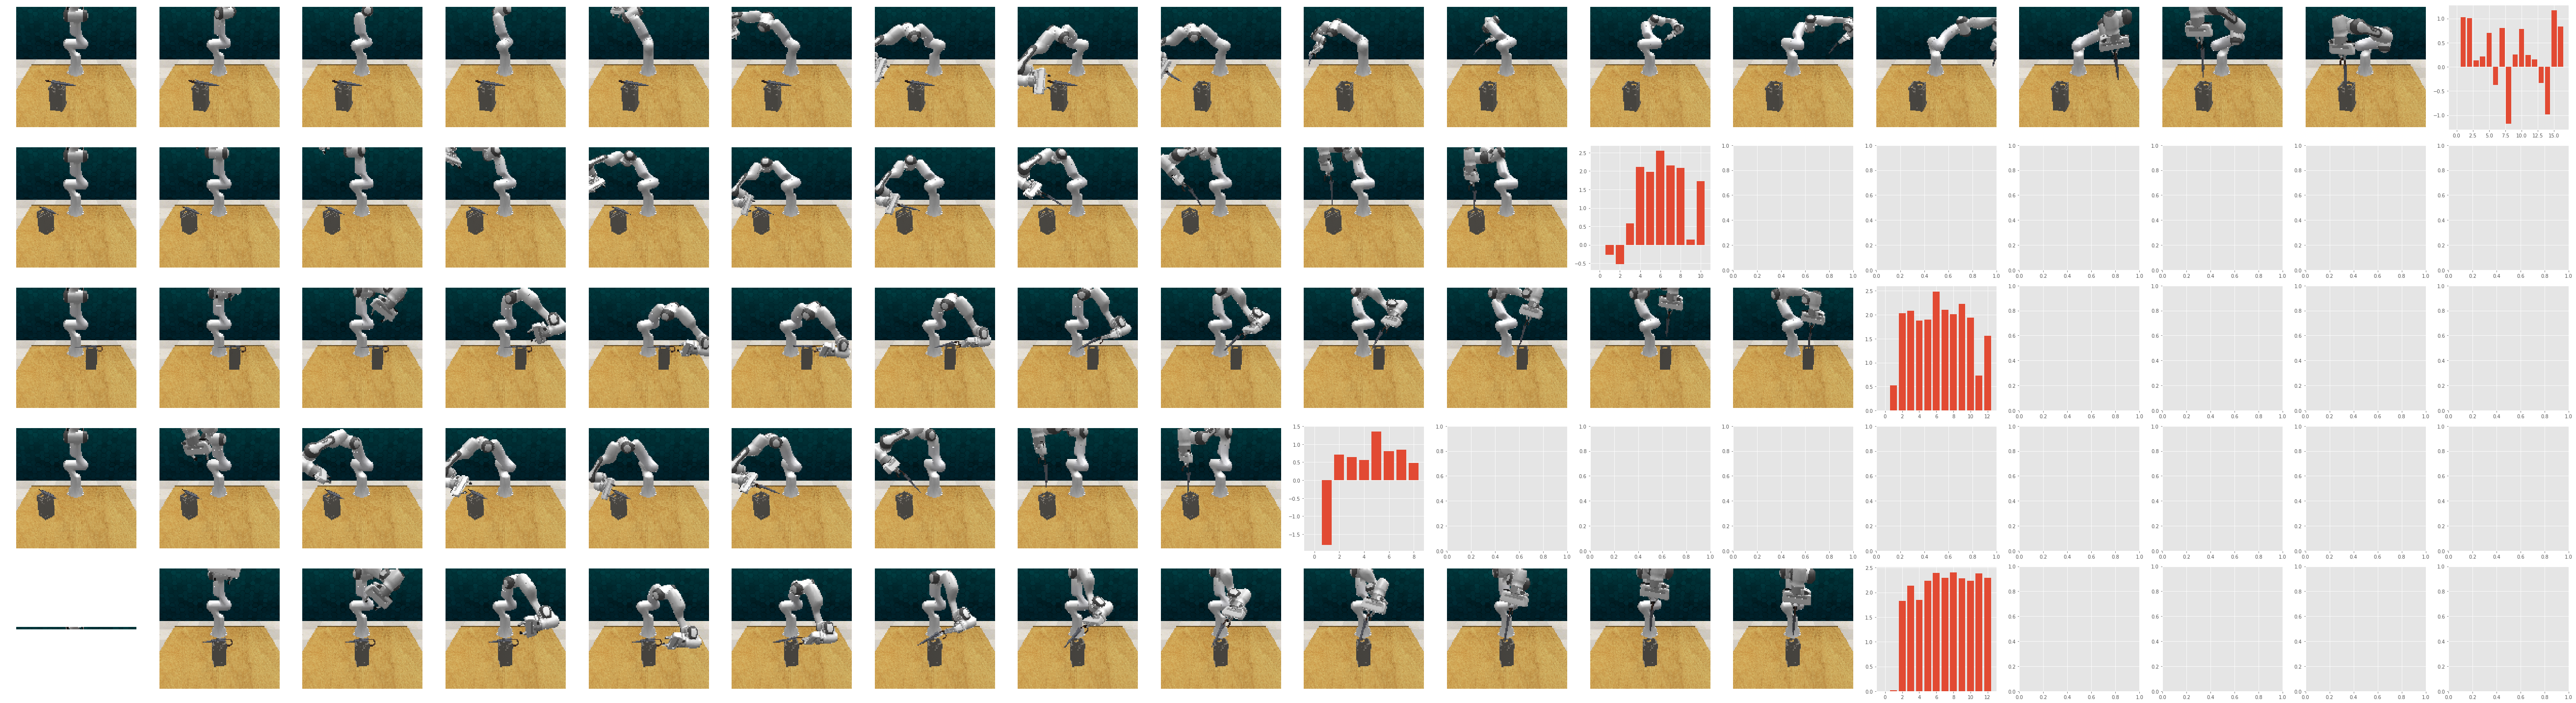

In [88]:
# task='take_lid_off_saucepan'

task='put_umbrella_in_umbrella_stand'
#task='take_lid_off_saucepan'
#task='take_money_out_safe'
# task='reach_target'
cam='front'
#cam='right_shoulder'
prompt = task.replace("_", " ")

all_task_imgs['_'.join([task,cam])] = \
load_demos(task=task, camera=cam, interval=15)
#get_imgs(task=task,traj_path='iteration0/success', n_paths=6)


all_task_rewards['_'.join([task, cam, 'r3m'])] = \
    get_r3m_rewards(
        all_task_imgs['_'.join([task,cam])], 
        prompt)

show_r3m_rewards(
    all_task_imgs['_'.join( [task,cam] )] ,
    all_task_rewards['_'.join([task, cam, 'r3m'])]
)

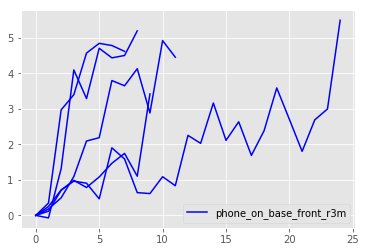

In [85]:
count = 0
colors = ['b', 'r', 'g']
plt.style.use('ggplot')
# plt.ylim(-130, 20)
for k, v in all_task_rewards.items():
    if task in k and cam in k:
        for i, rewards in enumerate(v):
            plt.plot([r for r in rewards], label=(k if i==0 else None), color=colors[count])
        count +=1
plt.legend()

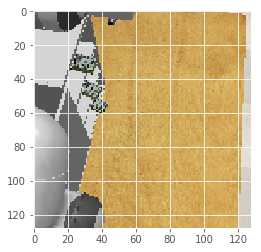

In [54]:
for k, v in all_task_imgs.items():
    if cam in k:
        plt.imshow(v[0][0])
        break

Getting demos for task close_drawer
9
8
8
6
6
Using caption Close drawer cabinet
One traj done
One traj done
One traj done
One traj done
One traj done


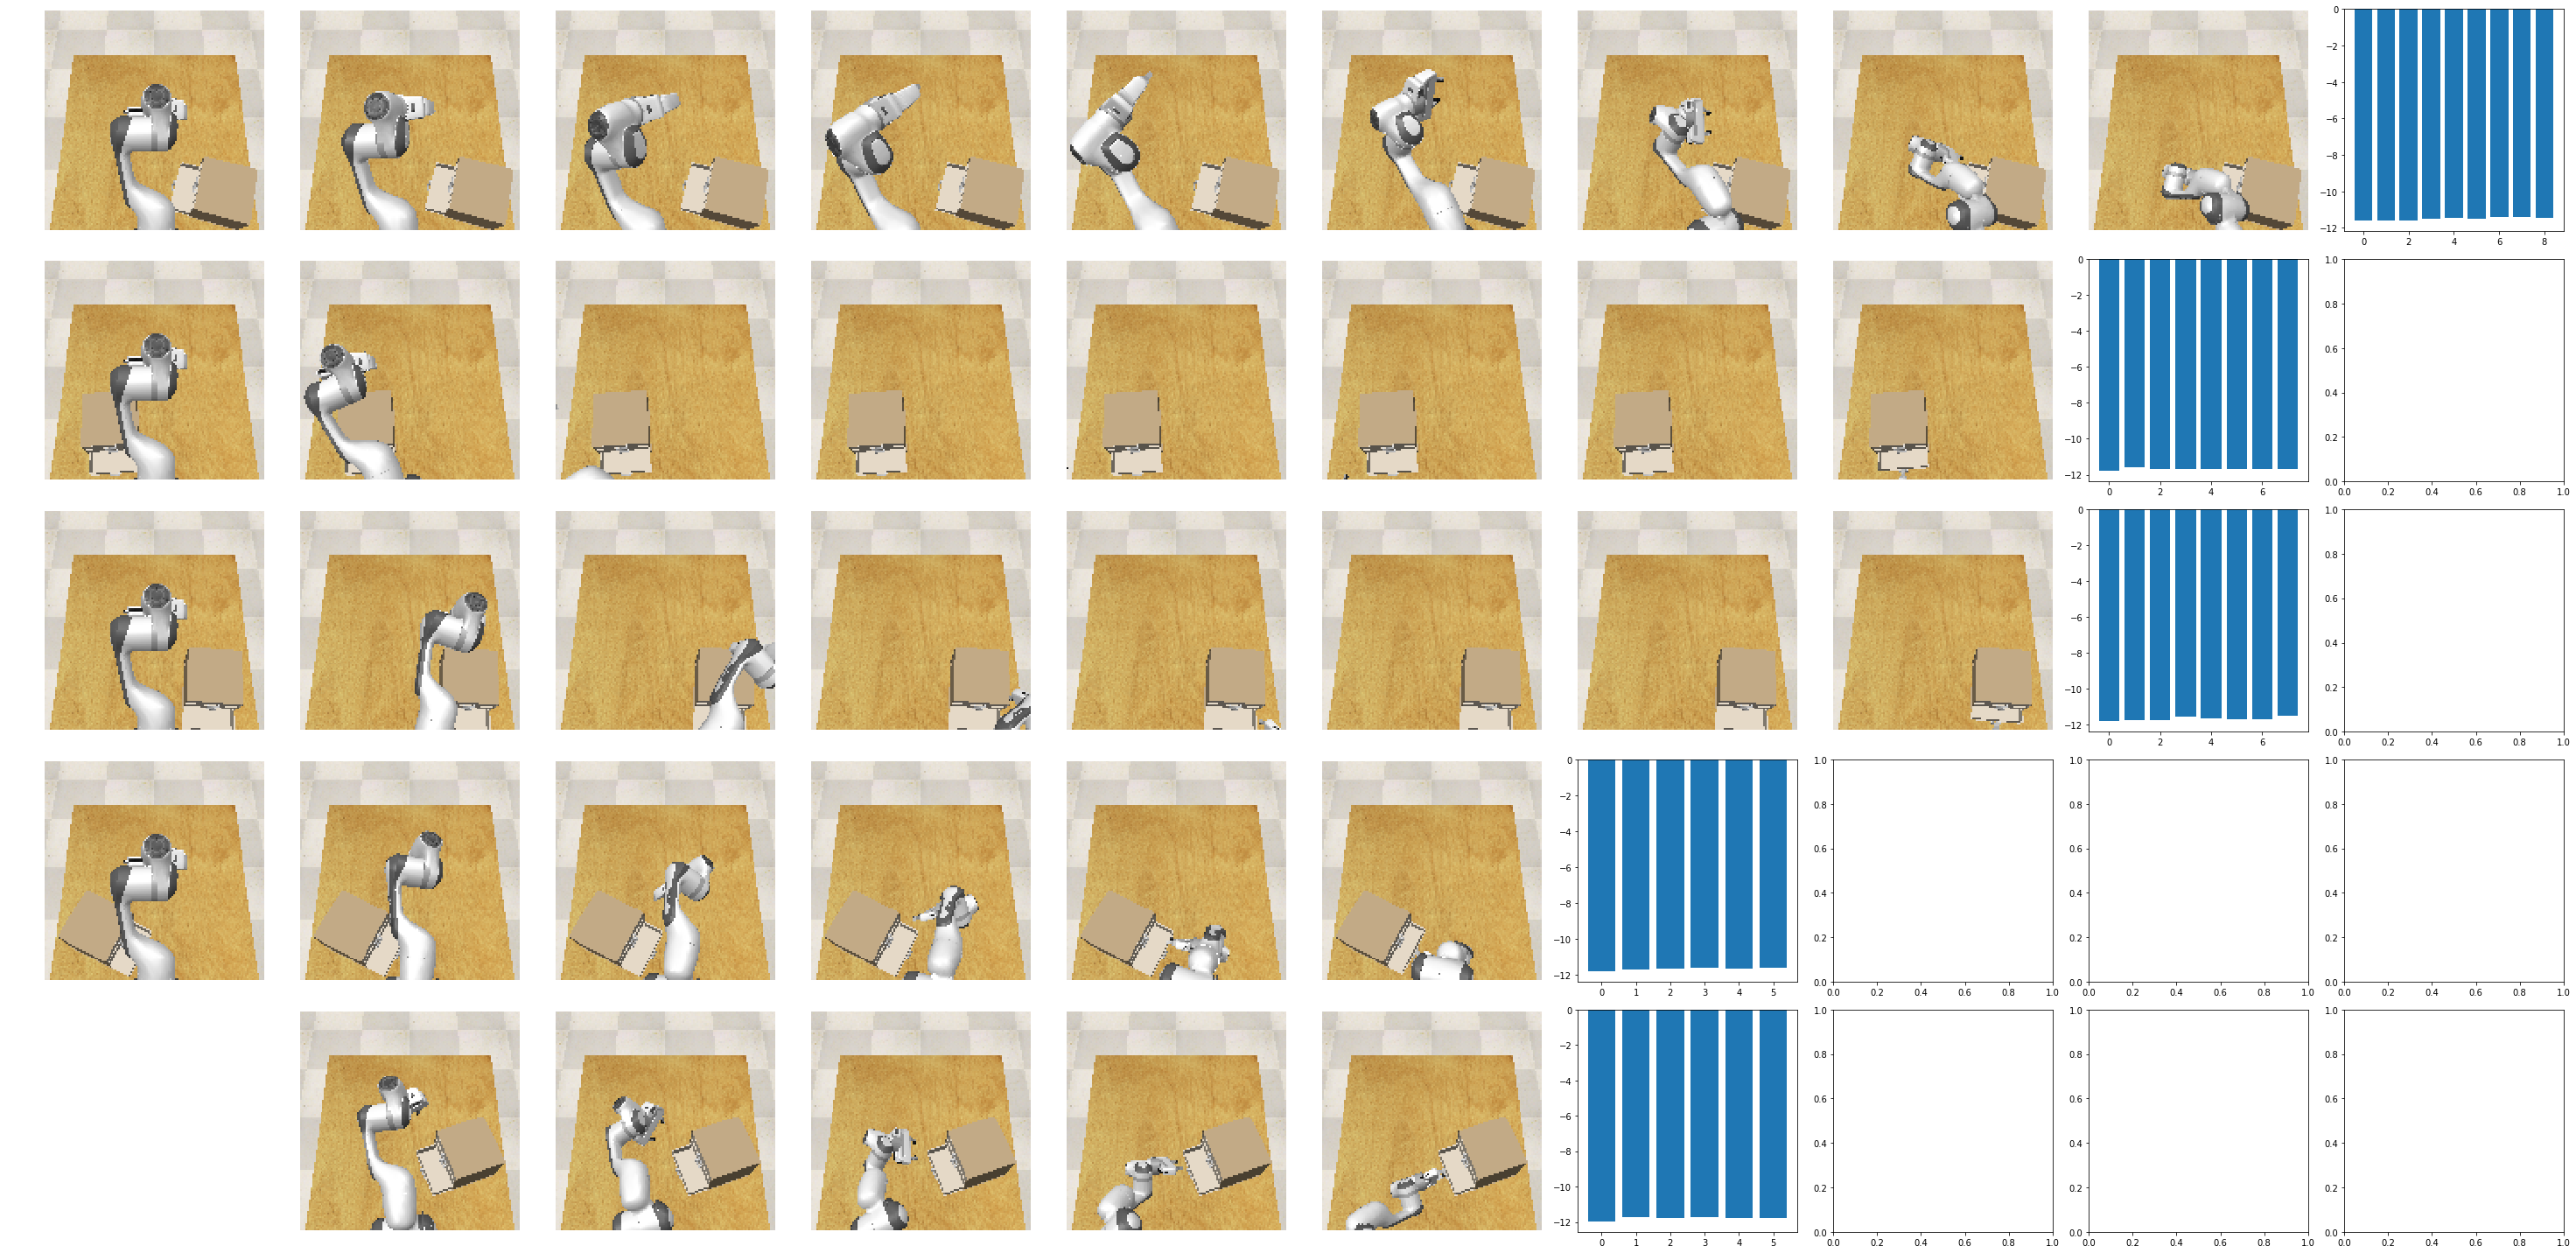

In [62]:
task='close_drawer'
# cam='right_shoulder'
cam='overhead'
# cam='front'
prompt = "Close drawer cabinet"

all_task_imgs['_'.join([task,cam])] = \
    load_demos(task=task, camera=cam, interval=15)

all_task_rewards['_'.join([task, cam, 'r3m'])] = \
    get_r3m_rewards(
        all_task_imgs['_'.join([task,cam])], 
        prompt)

show_r3m_rewards(
    all_task_imgs['_'.join( [task,cam] )] ,
    all_task_rewards['_'.join([task, cam, 'r3m'])]
)

One traj done
One traj done
One traj done
One traj done
One traj done


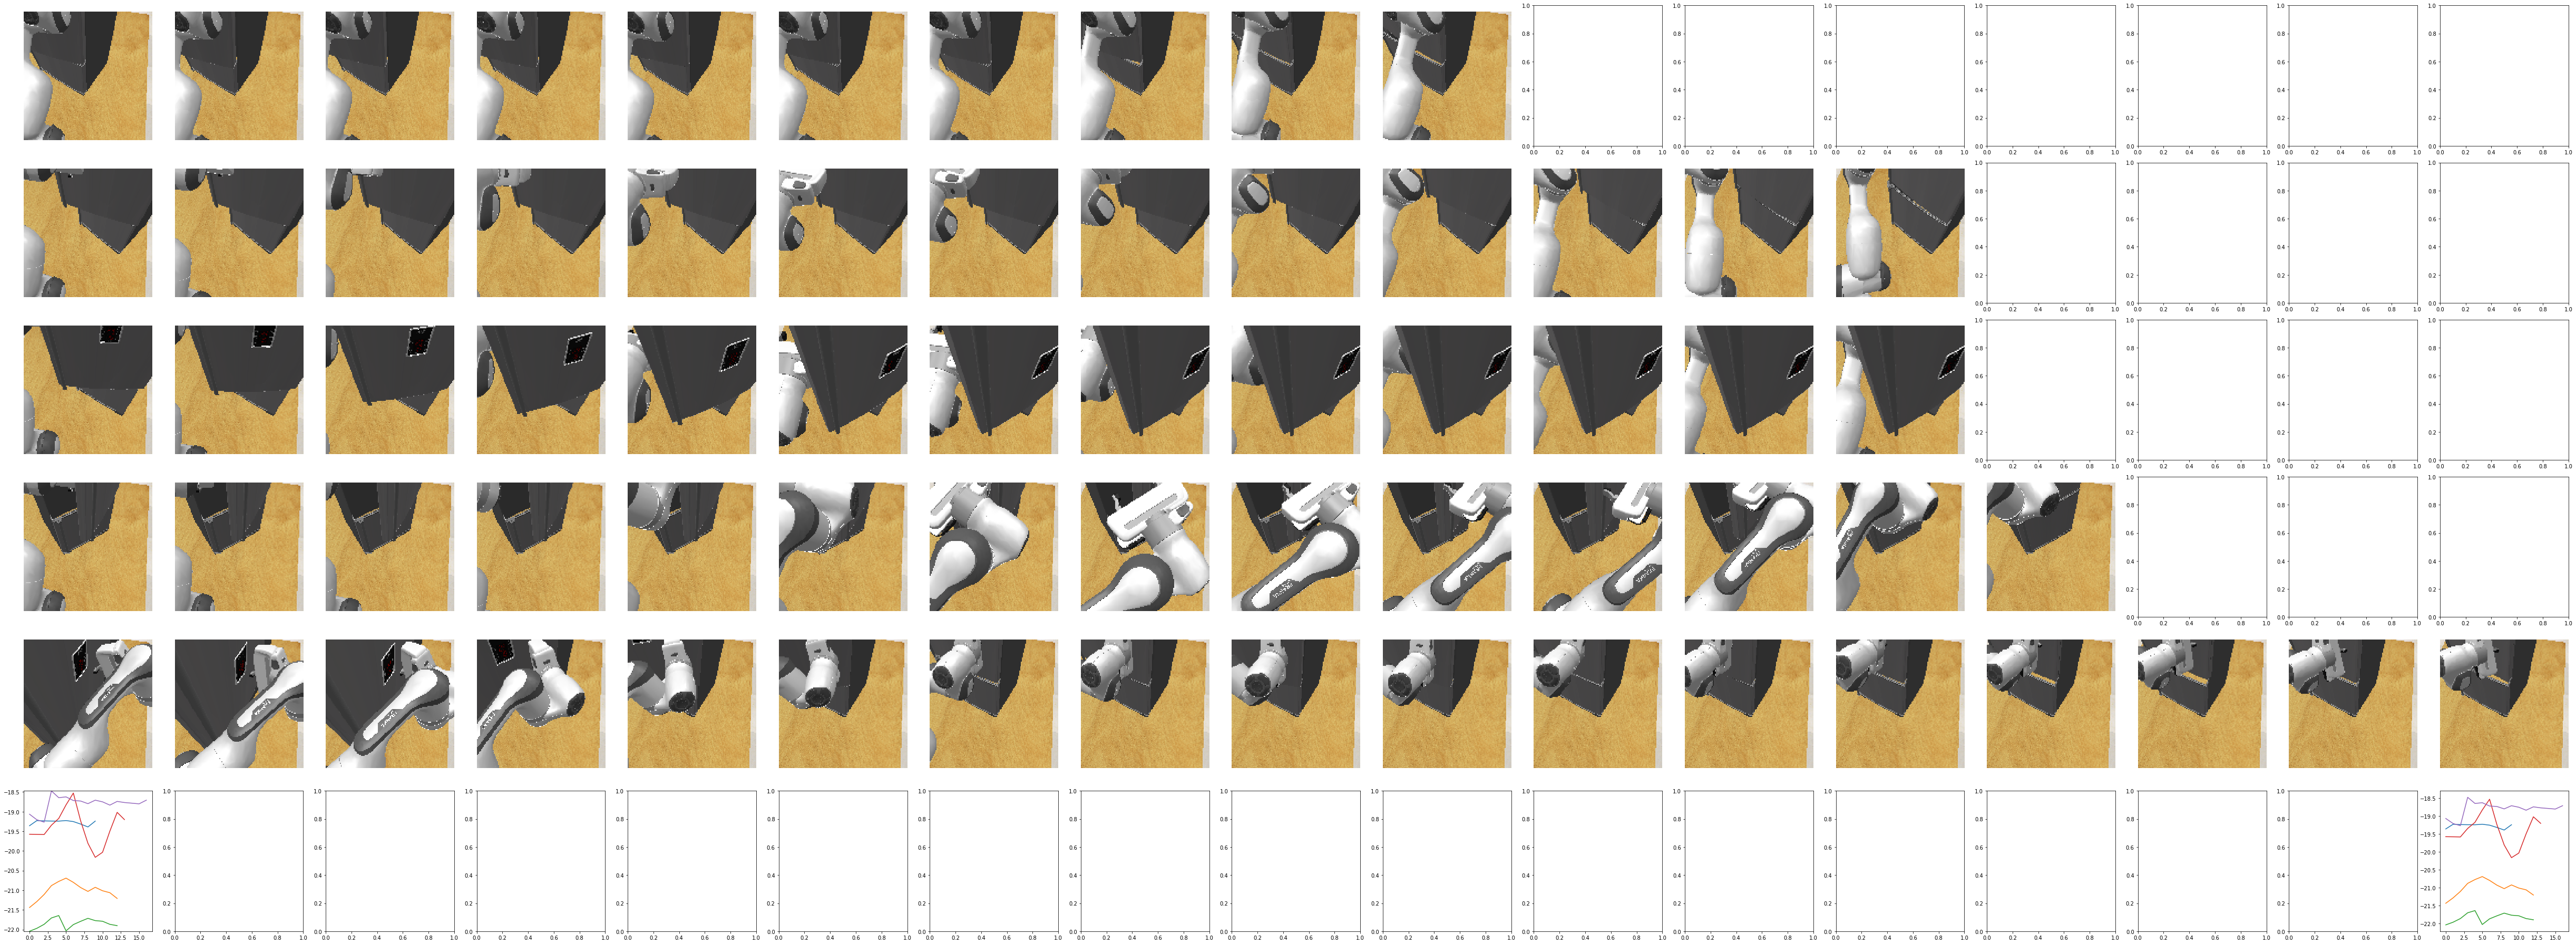

In [38]:
task='close_fridge'
cam='right_shoulder'     
%matplotlib inline
text="close the fridge"
all_imgs=dict()
all_rewards = dict()

all_imgs[task] = load_imgs(task=task, camera=cam, interval=10)
all_rewards[task] = get_rewards(all_imgs[task], text)
show_imgs(all_imgs[task], all_rewards[task])

One traj done
One traj done
One traj done
One traj done
One traj done


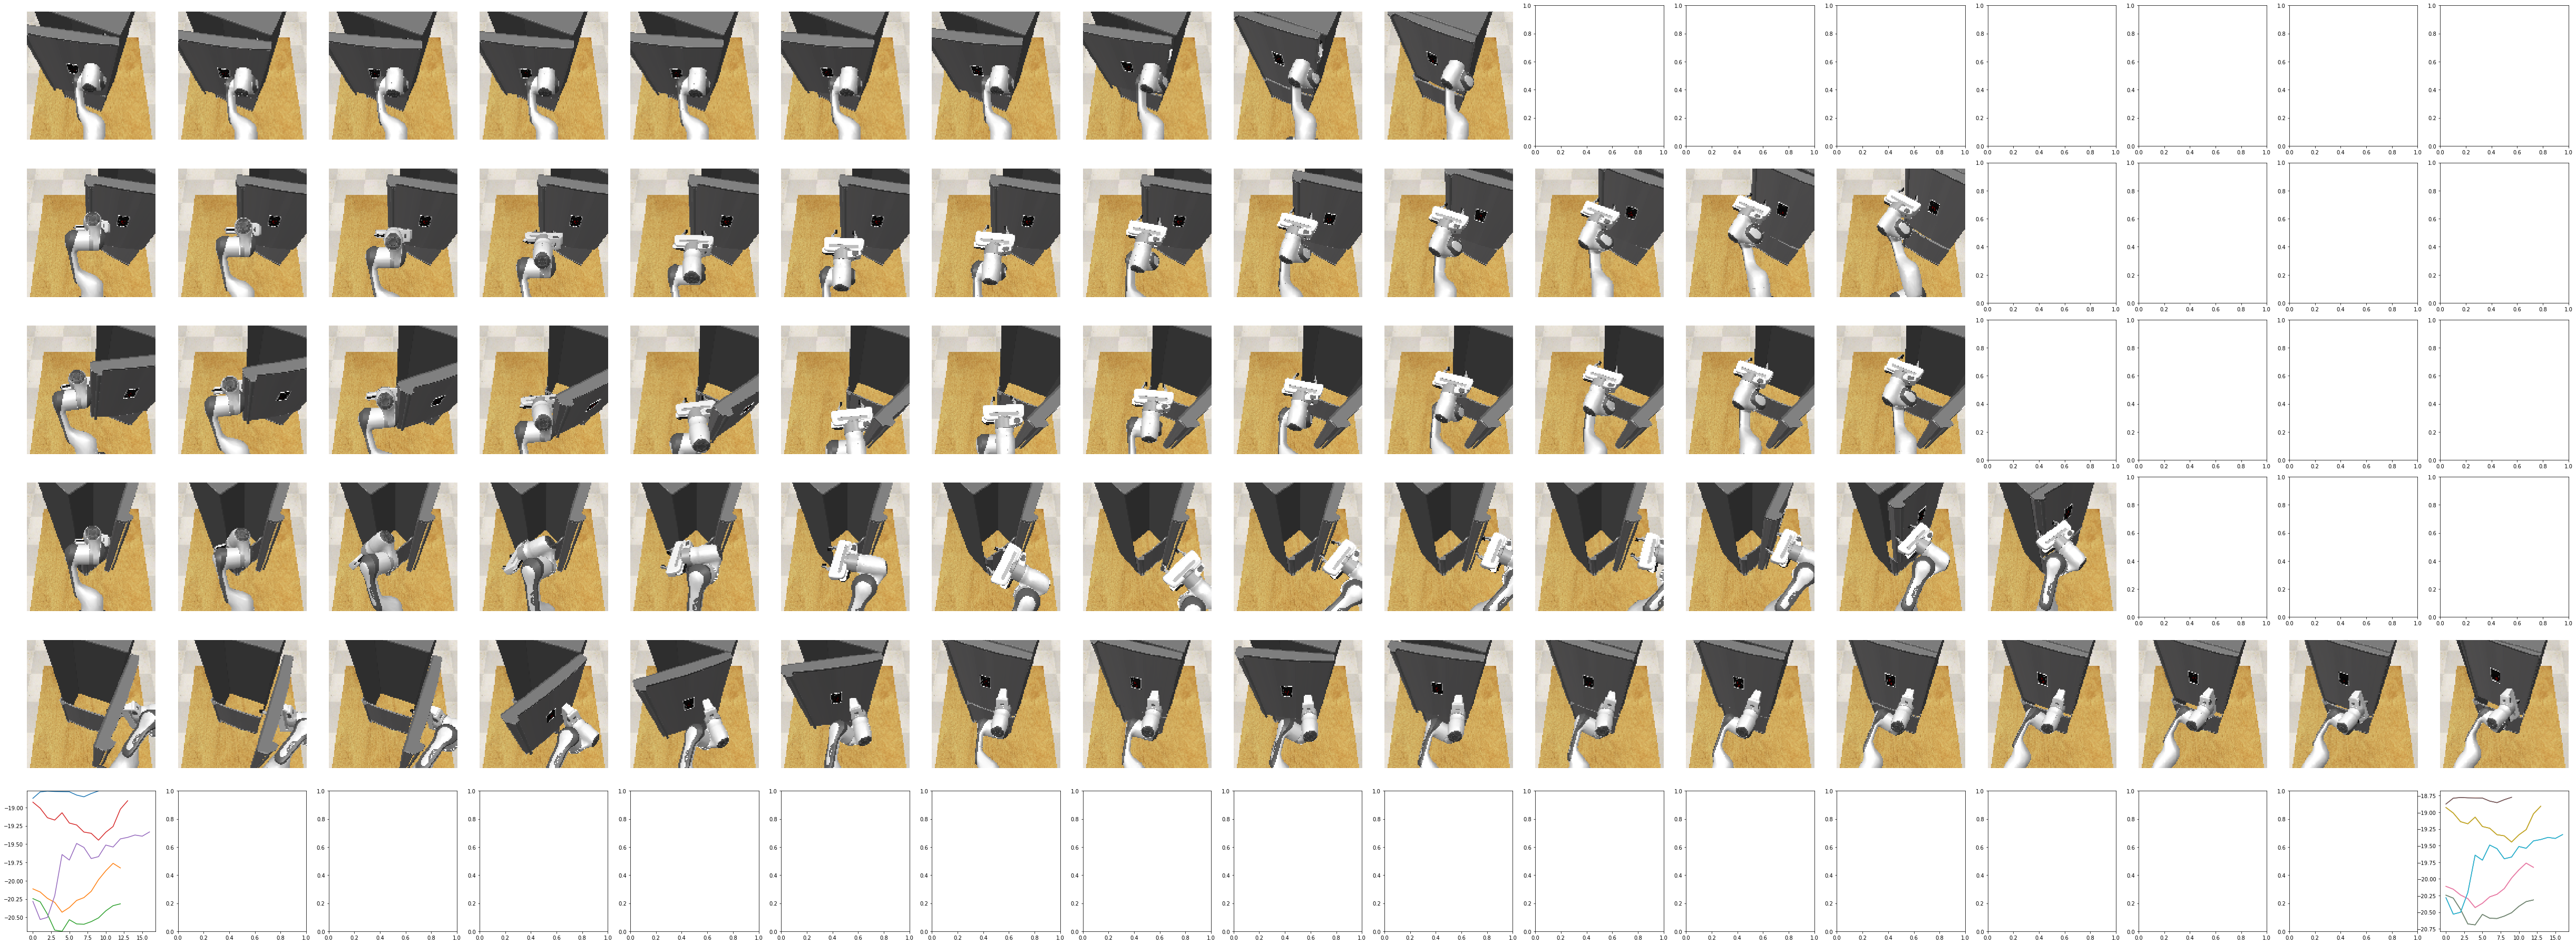

In [40]:
task='close_fridge'
cam='overhead'

%matplotlib inline
text="open the fridge"
all_imgs=dict()
all_rewards = dict()

all_imgs[task] = load_imgs(task=task, camera=cam, interval=10)
all_rewards[task] = get_rewards(all_imgs[task], text)
show_imgs(all_imgs[task], all_rewards[task])

for rewards in all_rewards[task]:
    plt.plot(rewards)

Text(0.5,1,'r3m vid-lang alignment scores for close the fridge')

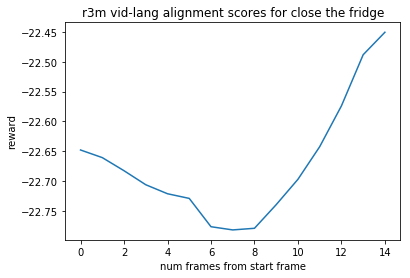

In [21]:
import numpy as np
from PIL import Image, ImageSequence

img = Image.open('/home/mandi/r3m/CloseFridge-right_shoulder_rgb.gif')
frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])
close_fridge = (((torch.as_tensor(frames) / 255.0) * 2) - 1).permute((0, 3, 2, 1))
close_fridge_display = torch.stack((close_fridge[80], close_fridge[-1])) 
# show_images(close_fridge_display)

start = close_fridge[80].unsqueeze(0)
start = r3m(start)
lang = np.array(["close the fridge"])
rewards = []
for i in range(15):
    end = close_fridge[80+i].unsqueeze(0)
    end = r3m(end)
    rewards.append(r3m.module.get_reward(start, end, lang)[0].cpu().detach())
plt.plot(rewards)
plt.xlabel("num frames from start frame")
plt.ylabel("reward")
plt.title("r3m vid-lang alignment scores for " + lang[0])

In [24]:
all_imgs['close_fridge'][0], close_fridge.max()

([<PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA9C933D0>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6C85A57E10>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA852AF50>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA9244D10>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA95BB310>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA989FDD0>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA9EA9050>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6C25ECEE50>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6C25ECEE10>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7F6CA8FD8290>],
 tensor(0.9529))

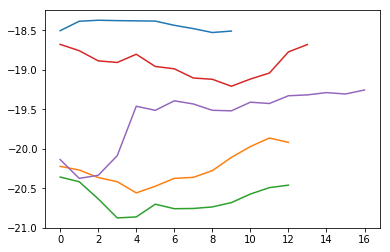

In [32]:
for rewards in all_rewards[task]:
    plt.plot(rewards)

Using caption open the door
One traj done
One traj done
One traj done
One traj done
One traj done


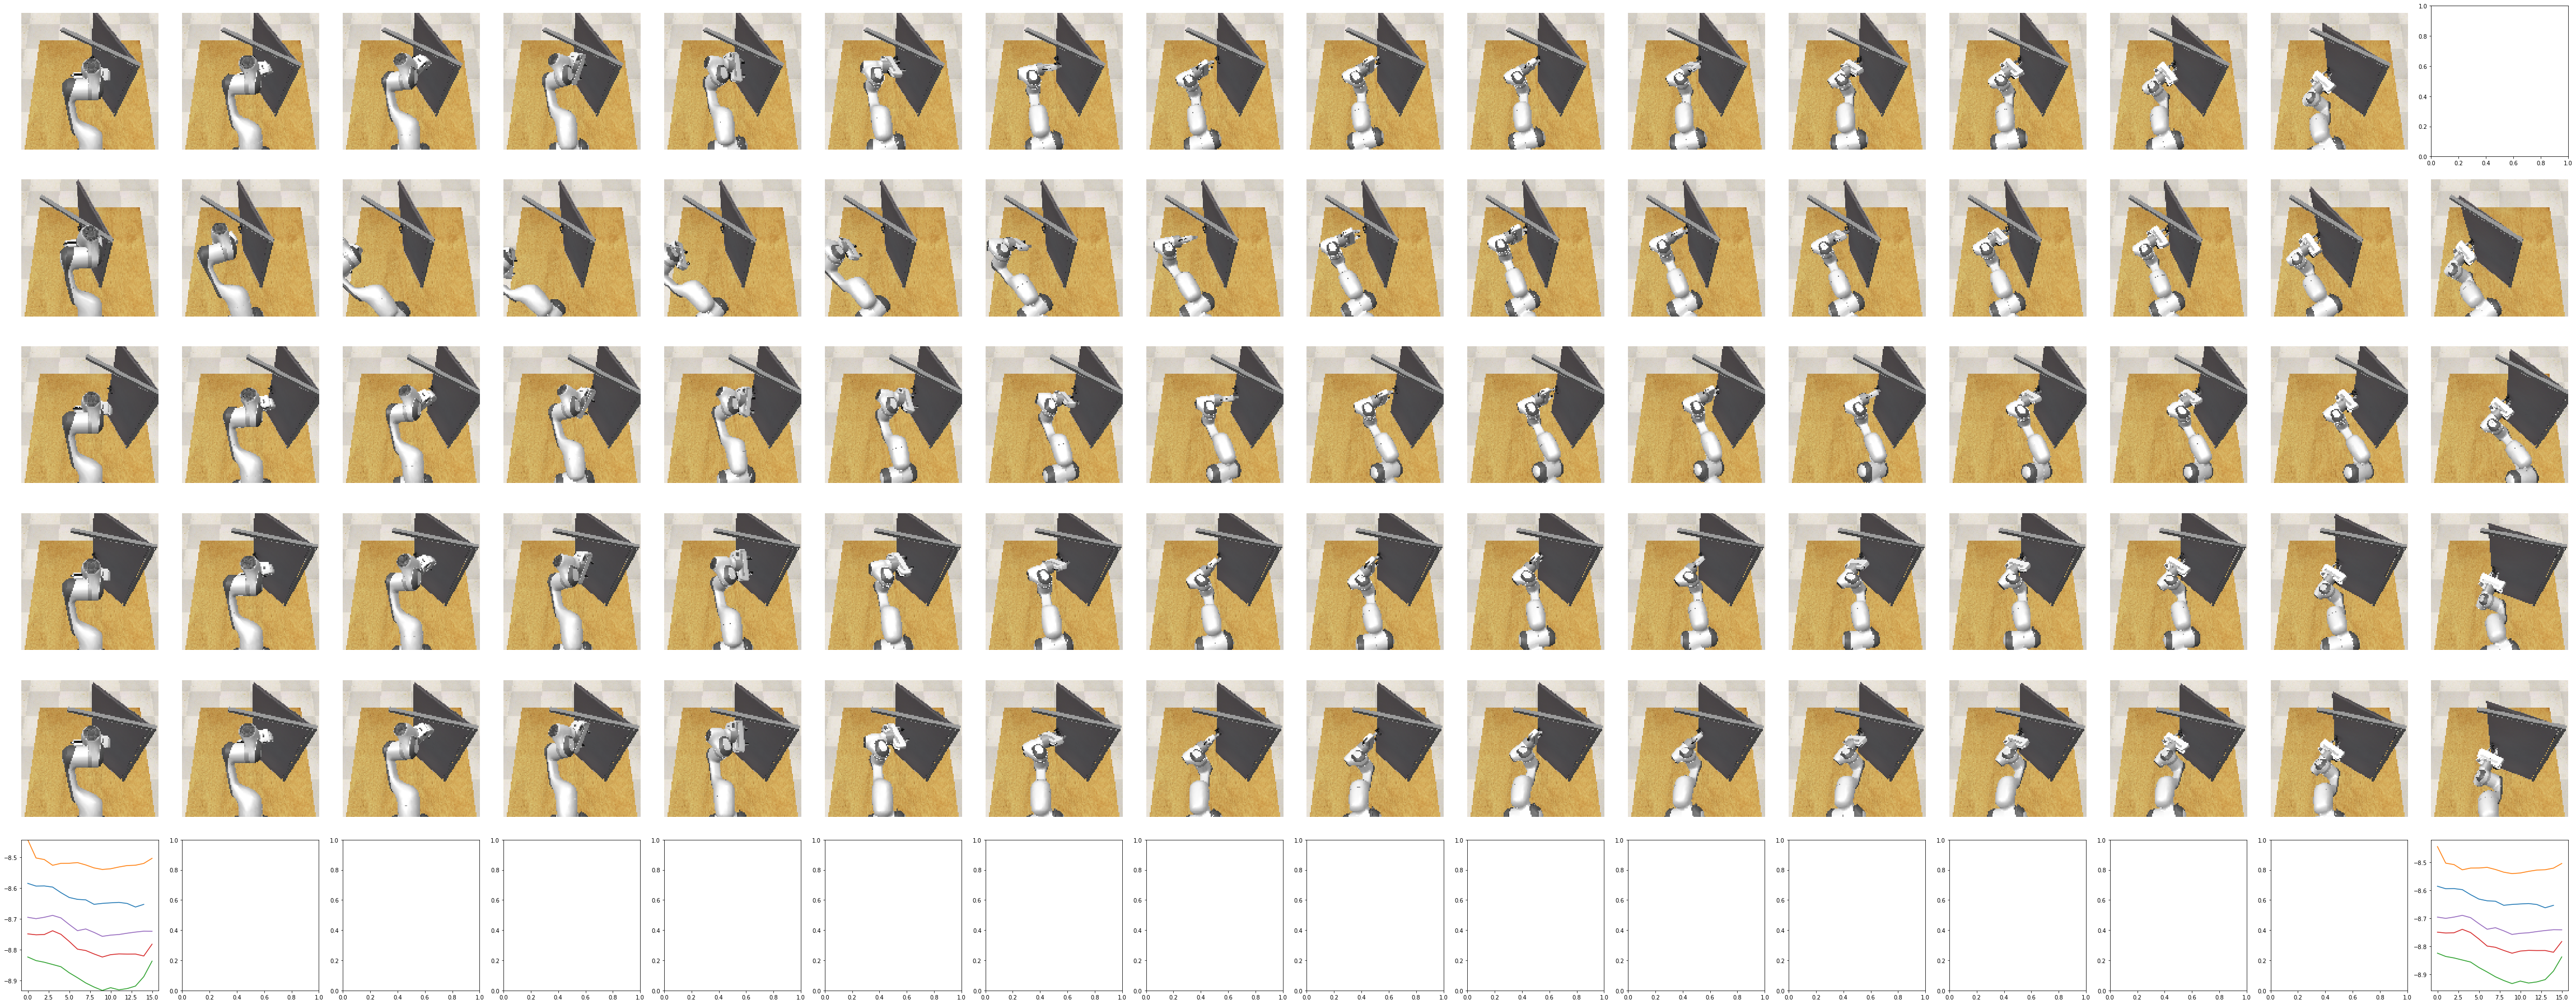

In [49]:
task='close_door'
#cam='right_shoulder'
cam='overhead'

%matplotlib inline
text="open the door"
all_imgs=dict()
all_rewards = dict()

all_imgs[task] = load_imgs(task=task, camera=cam, interval=10)
all_rewards[task] = get_rewards(all_imgs[task], text)
show_imgs(all_imgs[task], all_rewards[task])

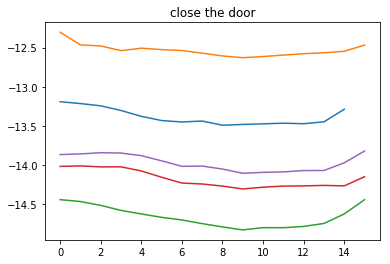

In [48]:
for rewards in all_rewards[task]:
    plt.plot(rewards)
    plt.title(text)

In [145]:
[print(m.to(device)) for m in r3m.parameters()]

Parameter containing:
tensor([[[[ 8.5168e-02,  1.9867e-02,  2.4229e-02,  ..., -8.9337e-02,
           -8.2752e-02, -2.4873e-02],
          [-4.4366e-02, -8.9062e-02, -1.1056e-01,  ..., -3.4003e-01,
           -2.0487e-01, -1.0462e-01],
          [ 6.3338e-02, -6.9348e-03, -2.2300e-02,  ..., -2.6037e-01,
           -1.3842e-01, -2.8910e-02],
          ...,
          [ 5.3961e-02,  4.0934e-02, -5.6996e-02,  ..., -3.8892e-01,
           -1.3522e-01, -1.7661e-02],
          [ 5.0430e-02, -5.8598e-02, -1.5869e-01,  ..., -4.8439e-01,
           -2.0100e-01, -1.2749e-01],
          [-1.6064e-03, -1.2615e-01, -2.6648e-01,  ..., -4.9473e-01,
           -2.2729e-01, -1.9911e-01]],

         [[ 7.4589e-02,  7.7007e-02,  8.9563e-02,  ...,  5.1093e-02,
            1.1626e-01,  1.1840e-01],
          [ 4.1804e-02,  1.0847e-01,  8.3613e-02,  ...,  7.8013e-02,
            9.8569e-02,  1.1015e-01],
          [ 8.2181e-02,  1.5808e-01,  1.0254e-01,  ...,  9.9058e-02,
            1.7726e-01,  1.7040e-01]

Parameter containing:
tensor([[[[ 0.1412,  0.1711,  0.1183],
          [ 0.1367,  0.1170,  0.2406],
          [-0.0064,  0.0495,  0.0392]],

         [[ 0.2430,  0.2124,  0.1549],
          [ 0.2007,  0.1269,  0.0917],
          [-0.0329, -0.0652, -0.1130]],

         [[-0.1675, -0.2696, -0.1309],
          [-0.2926, -0.2814, -0.1845],
          [-0.2518, -0.3138, -0.1870]],

         ...,

         [[ 0.1196,  0.0039, -0.0282],
          [ 0.0147, -0.0233, -0.0287],
          [ 0.0029, -0.0170,  0.0280]],

         [[ 0.0087,  0.0012, -0.0294],
          [-0.0084,  0.0408,  0.0414],
          [ 0.0871,  0.0075, -0.0273]],

         [[-0.0241, -0.0053,  0.1889],
          [ 0.1704,  0.1653,  0.1784],
          [ 0.1984,  0.1367,  0.2350]]],


        [[[ 0.0322, -0.0260,  0.0082],
          [-0.0597, -0.1019, -0.0706],
          [-0.1691, -0.1816, -0.2302]],

         [[ 0.0189,  0.0073,  0.0415],
          [ 0.0941,  0.0949,  0.0595],
          [-0.0410,  0.0574,  0.0255]],

         

Parameter containing:
tensor([-1.2323e-02, -1.7456e-01,  7.9201e-02,  1.8170e-02,  2.8468e-01,
         2.2522e-01, -1.8020e-01, -2.2775e-01, -3.5462e-02, -1.4164e-01,
        -2.0986e-02, -1.4361e-01, -4.4743e-02, -5.1358e-02,  2.3089e-01,
         3.9500e-02, -7.4473e-02, -6.0066e-02, -1.1258e-01,  6.5460e-02,
        -3.3848e-01, -1.1117e-01, -6.3812e-02, -7.5591e-02, -5.3779e-02,
         1.7849e-01, -7.8700e-02, -1.8412e-01, -1.6730e-01, -1.6798e-01,
        -1.0580e-01, -3.3320e-02, -2.7635e-01, -2.1075e-02, -1.1525e-01,
         8.1507e-02, -4.8181e-02, -1.9189e-01, -2.9195e-01, -1.1776e-02,
        -6.3327e-02,  2.3380e-02,  3.0509e-01,  2.0210e-02, -2.3514e-01,
        -9.2369e-02,  1.2233e-01,  2.1686e-01, -4.0501e-02, -1.3779e-02,
        -2.8516e-02, -6.7346e-02, -2.3049e-01, -1.3896e-01,  2.8108e-02,
        -2.5821e-02,  2.0675e-03,  6.2365e-02,  7.3624e-03, -4.0950e-02,
        -1.3480e-01, -2.7575e-01, -1.2026e-01,  1.8117e-01,  8.4312e-02,
         9.8026e-02, -2.7312e

Parameter containing:
tensor([[[[-3.5620e-02,  7.0291e-02, -2.4763e-03],
          [-3.8952e-02, -6.2763e-02, -2.4547e-01],
          [-9.8704e-03,  6.4449e-02,  1.0568e-01]],

         [[-3.3262e-03, -6.8946e-02, -6.0331e-02],
          [ 6.6756e-03,  6.2905e-02, -1.6152e-01],
          [ 1.7248e-02,  4.1211e-02, -2.4017e-02]],

         [[ 6.3633e-02,  1.9479e-01,  2.9337e-01],
          [-1.0925e-01, -1.4497e-02,  8.2533e-02],
          [-9.1108e-02, -1.2380e-01, -1.1602e-01]],

         ...,

         [[ 4.3471e-02, -4.8623e-02,  3.3332e-03],
          [ 7.3405e-02, -1.3378e-01, -6.7081e-02],
          [-5.5331e-02, -1.3298e-01,  2.4469e-02]],

         [[ 8.9123e-02,  1.2340e-01,  2.2119e-01],
          [ 3.3771e-02, -1.3088e-01, -2.6001e-02],
          [ 4.5584e-02, -1.6364e-01, -1.5777e-01]],

         [[ 1.0458e-02, -1.6438e-02, -9.0907e-02],
          [-3.6355e-02, -6.9181e-02, -1.0190e-01],
          [-6.4597e-02, -5.0455e-02, -2.4224e-02]]],


        [[[-5.3838e-02, -9.7718

Parameter containing:
tensor([[[[ 3.1713e-01,  1.4409e-01,  6.0579e-02],
          [ 2.4079e-01,  8.4137e-02,  5.7852e-02],
          [ 1.8587e-01,  1.3688e-01,  1.0723e-01]],

         [[-8.8329e-02, -5.6649e-02, -4.4467e-02],
          [-1.8385e-01, -2.9002e-01, -1.1580e-01],
          [-2.0751e-01, -1.6976e-01, -1.7574e-01]],

         [[-2.7416e-01, -1.8929e-01, -2.2210e-01],
          [-3.8301e-01, -2.2573e-01, -1.8654e-01],
          [-2.7376e-01, -3.1231e-01, -1.5440e-01]],

         ...,

         [[-8.1007e-02, -7.1061e-02, -5.7014e-02],
          [ 1.0855e-01,  1.6598e-02, -1.5556e-01],
          [ 1.1529e-02, -1.1964e-01, -3.1589e-01]],

         [[-4.1944e-02,  3.8787e-02,  3.3500e-02],
          [ 1.3012e-01,  1.3190e-01,  9.3764e-02],
          [ 6.1694e-02,  1.2931e-01,  4.2817e-02]],

         [[ 6.6359e-02,  1.3095e-01, -3.1347e-02],
          [ 1.6955e-02,  2.1159e-02,  9.9799e-02],
          [-1.0471e-01, -4.2183e-02, -1.9111e-02]]],


        [[[ 4.0187e-02, -3.6525

Parameter containing:
tensor([ 1.0422e-03,  3.5183e-04, -2.4624e-03, -1.0610e-04, -1.1928e-03,
         2.6924e-03,  2.2760e-03,  8.4075e-04,  2.2369e-03,  8.5693e-04,
         9.5765e-04,  1.4069e-03,  6.3270e-04, -1.6676e-03, -3.9765e-03,
         1.9308e-03,  2.1222e-04, -6.6218e-03, -9.6431e-04, -1.3681e-03,
         2.8614e-03,  3.8682e-03, -5.1349e-04,  8.7635e-04,  5.8924e-04,
        -3.4491e-03, -1.0485e-03, -2.9199e-04, -3.7495e-03, -1.1197e-02,
        -3.0307e-03, -9.7107e-04, -1.7841e-03,  1.2601e-03,  1.1211e-03,
         1.1742e-03, -5.4190e-04, -3.1820e-03,  2.5914e-03,  2.1792e-04,
        -3.3515e-04, -4.9323e-04, -1.8145e-03, -8.6360e-03, -2.5327e-03,
        -3.0776e-03, -2.6668e-04, -5.3296e-04,  1.7150e-03, -4.5986e-04,
        -1.3011e-03,  6.0363e-04,  9.6584e-04, -4.4845e-03,  1.1877e-03,
        -1.5512e-03,  2.0457e-03,  2.3995e-03,  1.0429e-03, -7.9153e-04,
        -1.9309e-03,  4.0078e-03, -1.5509e-03, -2.8468e-03, -4.1585e-03,
        -2.2366e-03,  3.0944e

Parameter containing:
tensor([ 0.0175,  0.1208, -0.0588,  0.0809,  0.0109,  0.0086, -0.0637,  0.0084,
        -0.0372,  0.0342,  0.0155, -0.0050,  0.1029, -0.2184,  0.0385,  0.0794,
         0.0187, -0.0872,  0.0415, -0.1248, -0.2090, -0.0165, -0.0295, -0.1194,
        -0.0365, -0.0575, -0.1642,  0.0721,  0.0351,  0.0593,  0.0895, -0.1590,
         0.0630,  0.0172,  0.0429,  0.1377,  0.1265, -0.0856, -0.0339, -0.0067,
        -0.0428,  0.0147,  0.0229, -0.0645,  0.0949, -0.1287, -0.0166,  0.0248,
         0.0226, -0.0169,  0.0703, -0.0135,  0.0191,  0.0768,  0.1248, -0.1032,
        -0.1425, -0.0619, -0.0460, -0.0133,  0.1184,  0.1726, -0.0247,  0.0048,
        -0.0387, -0.0880, -0.0448, -0.0861, -0.1236, -0.0302, -0.0169,  0.0863,
         0.0224, -0.1611, -0.0034, -0.1337,  0.0526, -0.1630,  0.0066, -0.1433,
         0.0296,  0.0392, -0.0115, -0.0385, -0.0296, -0.0715,  0.1487, -0.1371,
        -0.0387, -0.0060, -0.0575,  0.0092, -0.1407,  0.1214,  0.0175, -0.0273,
         0.1375,  

Parameter containing:
tensor([-7.1372e-04,  1.5684e-03, -3.0177e-02, -2.5391e-01,  2.9456e-01,
        -1.4197e-01,  2.1364e-01,  6.4206e-02, -3.9015e-03, -9.9685e-02,
        -1.2590e-01,  2.3839e-01, -6.8903e-02,  1.0826e-01,  7.3155e-03,
         9.8618e-02, -1.1484e-01, -3.1509e-02, -8.9134e-02,  2.6505e-01,
         2.4741e-01, -2.6666e-01,  1.1124e-01,  3.1034e-01, -3.1554e-02,
         2.8049e-01,  1.2985e-01, -2.6104e-01, -2.8322e-01,  6.5496e-02,
        -2.6041e-02,  3.9296e-02,  2.6555e-01, -2.2068e-01,  8.2567e-02,
        -2.2421e-02, -1.4049e-01,  2.4176e-01,  1.8128e-01, -4.2856e-01,
        -8.7075e-02, -1.9876e-01, -3.9451e-03,  1.0991e-01,  9.4433e-03,
        -1.5059e-01, -1.1742e-01, -1.1703e-01,  1.8849e-02, -1.3600e-01,
        -2.6349e-01, -8.0215e-02,  2.4342e-01, -4.4926e-01,  5.8122e-02,
        -9.0309e-02,  8.3147e-02, -2.9559e-01, -1.4696e-02, -8.1882e-02,
        -7.5660e-02,  5.5072e-02, -2.6172e-01, -1.7673e-01,  2.6345e-02,
         1.1292e-01, -3.7103e

Parameter containing:
tensor([[-0.0302, -0.0032, -0.0500,  ...,  0.0386,  0.0315,  0.0042],
        [-0.0063, -0.0499, -0.0609,  ...,  0.0562, -0.0340,  0.0130],
        [-0.0521,  0.0116, -0.0109,  ..., -0.0625, -0.0743, -0.0313],
        ...,
        [ 0.0275, -0.0355,  0.0037,  ..., -0.0021,  0.0240, -0.0184],
        [-0.0422, -0.0791, -0.0232,  ...,  0.0030, -0.0895, -0.0417],
        [ 0.0574,  0.0443, -0.0479,  ...,  0.0822,  0.0363, -0.0123]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-5.1293e-03,  8.3283e-03,  3.7761e-03,  9.2902e-03, -4.1819e-03,
        -8.0359e-03,  3.5739e-03,  5.2771e-03, -3.3362e-03,  3.7618e-03,
        -1.5047e-02, -2.0224e-04,  5.4226e-04,  1.0057e-02, -3.7476e-03,
         3.0773e-03, -5.6142e-03, -5.8516e-03,  3.1472e-03, -3.6907e-03,
        -3.6817e-03, -9.4853e-03, -8.8480e-03,  9.3861e-03, -8.3188e-04,
        -8.7129e-06,  7.3194e-03, -1.2638e-03, -7.3551e-03, -7.0271e-04,
         1.2134e-02,  5.2247e-03,  7.118

Parameter containing:
tensor([-8.3510e-02, -1.0967e-02, -4.9583e-02, -5.7309e-02,  1.0742e-01,
         4.5025e-02,  1.4145e-02, -1.9214e-02, -1.4706e-01, -1.2015e-01,
        -1.0074e-01, -7.7587e-03, -1.3896e-01,  1.5117e-02, -7.0269e-02,
         3.6003e-02,  6.4629e-02,  4.7116e-02, -2.1266e-02, -8.6252e-02,
        -6.1005e-02, -4.9372e-02,  4.4047e-02,  1.6547e-02,  2.0149e-02,
        -4.2598e-02,  2.7900e-03, -6.1695e-02, -8.9894e-02,  6.0897e-03,
         7.5720e-02, -7.8819e-02, -2.8135e-02, -4.8725e-02, -1.5305e-01,
        -8.2032e-02, -4.9965e-02, -9.4385e-03, -7.0010e-02, -1.1095e-01,
        -1.6241e-01, -1.3363e-01, -6.4598e-02, -2.7483e-02, -9.6446e-02,
        -6.5471e-02, -1.3703e-01,  2.5869e-02, -6.6452e-02, -5.9249e-02,
        -1.5687e-01,  6.1087e-02, -4.6764e-03,  2.9703e-02,  3.2057e-02,
        -2.4774e-02, -1.4765e-01, -4.3204e-02, -7.9012e-02, -1.0809e-01,
        -3.1360e-02,  6.9092e-03,  1.2391e-01, -6.3726e-02,  2.0571e-02,
         3.7220e-02,  1.4372e

Parameter containing:
tensor([-4.9963e-02,  4.7065e-02,  1.0054e-02, -4.7979e-03,  6.3195e-02,
         6.4710e-02,  3.1224e-02, -6.3866e-02, -4.5398e-03, -9.4894e-02,
        -9.7866e-02,  5.0355e-02, -8.4450e-02,  8.1986e-02,  5.8915e-02,
         1.2138e-01,  1.7280e-02, -7.7663e-03,  2.9521e-02, -2.7841e-02,
         2.9386e-02,  2.6991e-03,  6.1953e-03,  8.9229e-03,  3.1832e-02,
        -1.8491e-02,  6.4577e-02,  6.8804e-02, -1.3249e-02, -1.3048e-02,
        -5.7861e-03,  4.8795e-02,  4.5455e-02, -8.0077e-02,  2.9304e-02,
        -1.7812e-02, -3.0185e-02, -8.9534e-03,  2.7955e-02, -6.1137e-02,
         5.2232e-04, -7.5698e-03, -3.6577e-02,  2.1869e-02,  5.8161e-02,
         4.7506e-02, -8.4447e-02,  8.2236e-02, -1.0157e-01, -7.6773e-02,
        -7.9561e-03,  6.0607e-02,  7.7176e-02,  1.0161e-03, -1.9332e-02,
         6.7107e-02, -4.8764e-02,  5.5376e-02,  3.5886e-02,  4.6946e-02,
        -9.2216e-03, -1.8921e-02,  6.3080e-02, -7.3857e-03, -4.0072e-02,
        -6.1438e-02,  5.6004e

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

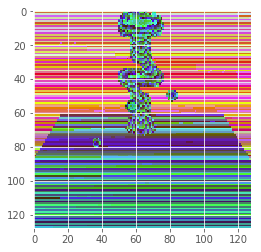

In [165]:
dep = Image.open('/shared/mandi/all_rlbench_data/reach_target/variation0/episodes/episode0/front_depth/0.png')
plt.imshow(dep)

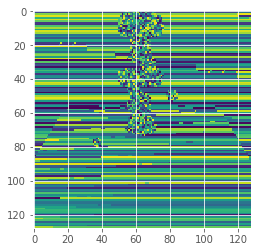

In [166]:
plt.imshow(np.array(dep)[:,:,2])

In [160]:
dep.shape

AttributeError: shape